# LightGBM model (product level)

This model first aggregates time series at the product level, then builds features.  
Note that this is different from the bottom-up LightGBM where we first build features and predict using (reporterhq_id, product_number) as keys and then later aggregate the values.  

We aggregate the dataset using ("date", "product_number") as key.  
While doing this we explode the column "reporterhq_id" into multiple ones, 2 for each "reporterhq_id" (inventory, sales). Inside each row we store the partial sum of ("date", "product_number", "reporterhq_id").


1. **Load and preprocess**
   - Load data
   - Aggregate at the product level
   - Preprocess
   - Features generation

2. **Hyperparameters validation**  
   Performs a TimeSeriesSplit to find the best set of parameters for the LightGBM model.  
   This si done with a RandomizedSearchCV excluding the last 2 batches of 13 weeks.     
   We will use the latter as a test set for the model evaluation.  
   
3. **Model evaluation**  
   Evaluates the model on the last 2 batches of 13 weeks.

4. **Visualisation**  
   Plots some of the time series along with the predicted values.

## 1. Load and preprocess

In [1]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
import utils.constants as constants
from utils.utils_models import LightGBMForecastingModel
from sklearn.model_selection import TimeSeriesSplit

sns.set_theme(style="darkgrid")

In [5]:
df_kaggle = pd.read_csv(constants.file_path)

In [6]:
df_agg = utils.aggregate_df(df_kaggle)

In [7]:
df_agg.columns

Index(['date', 'product_number', 'inventory_units', 'sales_units',
       'inventory_units_3', 'inventory_units_6', 'inventory_units_9',
       'inventory_units_12', 'inventory_units_15', 'inventory_units_21',
       'inventory_units_24', 'inventory_units_27', 'inventory_units_36',
       'inventory_units_39', 'inventory_units_48', 'inventory_units_60',
       'inventory_units_72', 'inventory_units_78', 'inventory_units_81',
       'inventory_units_84', 'inventory_units_87', 'inventory_units_90',
       'inventory_units_93', 'inventory_units_96', 'sales_units_3',
       'sales_units_6', 'sales_units_9', 'sales_units_12', 'sales_units_15',
       'sales_units_21', 'sales_units_24', 'sales_units_27', 'sales_units_36',
       'sales_units_39', 'sales_units_48', 'sales_units_60', 'sales_units_72',
       'sales_units_78', 'sales_units_81', 'sales_units_84', 'sales_units_87',
       'sales_units_90', 'sales_units_93', 'sales_units_96', 'id', 'year_week',
       'reporterhq_id', 'prod_catego

In [8]:
df_agg = utils_preprocessing.preprocess_columns(df_agg, bottom_up=False)

# Generate features
df_agg = utils_features.features_time_related(df_agg)
df_agg = utils_features.features_lag(df=df_agg, col='inventory_units', lags=[13, 14, 15], group_column='product_number')
df_agg = utils_features.features_lag(df=df_agg, col='sales_units', lags=[13, 14, 15], group_column='product_number')
df_agg = utils_features.features_rolling(df=df_agg, col='inventory_units', window_sizes=[4, 8], group_column='product_number')
df_agg = utils_features.features_rolling(df=df_agg, col='sales_units', window_sizes=[4, 8], group_column='product_number')
df_agg = utils_features.create_periods_feature(df_agg, coll_agg='product_number', date_column='date', target_col='inventory_units')

df_agg = df_agg.rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["first_nonzero_signal"] = df.groupby(coll_agg)["signal_above_zero"].cumsum() > 0
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["feature_periods"] = df.groupby(coll_agg).cumcount() + 1


## 2. Hyperparameters validation

In [25]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_agg, forecasting_horizon=13*2, target_col="y")

In [26]:
cv_split = TimeSeriesSplit(n_splits=10, test_size=13)

In [27]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    'verbosity': [-1],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=13),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'verbosity': [-1]},
                   verbose=1)

In [28]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [11]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'num_leaves': 10,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 50,
 'reg_lambda': 10,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse'}

## 3. Model evaluation

In [30]:
optimal_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 0.3,
    'importance_type': 'split',
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 900,
    'n_jobs': None,
    'num_leaves': 200,
    'objective': 'regression',
    'random_state': None,
    'reg_alpha': 5,
    'reg_lambda': 100,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'verbosity': -1,
    'metric': 'rmse'
    }

In [31]:
tss = TimeSeriesSplit(2, test_size=13)

In [33]:
fc_model = LightGBMForecastingModel(
    hyperparameters=optimal_params
    )
results_cv = fc_model.cross_validate(df_agg, n_splits=2, bottom_up=False)

Average RMSE from cross-validation: 31.7550


In [12]:
fc_model = LightGBMForecastingModel(
    hyperparameters=optimal_params
    )
fc_model.train(X_train, y_train)
fc_model.save_model("./models/lightgbm.pk")

## 4. Visualisation

In [17]:
df_preds = utils.predict_last_13_weeks(df_agg, fc_model, col_agg='product_number')
df_final = df_agg.merge(df_preds.reset_index(), on=['date', 'product_number'], how='left')

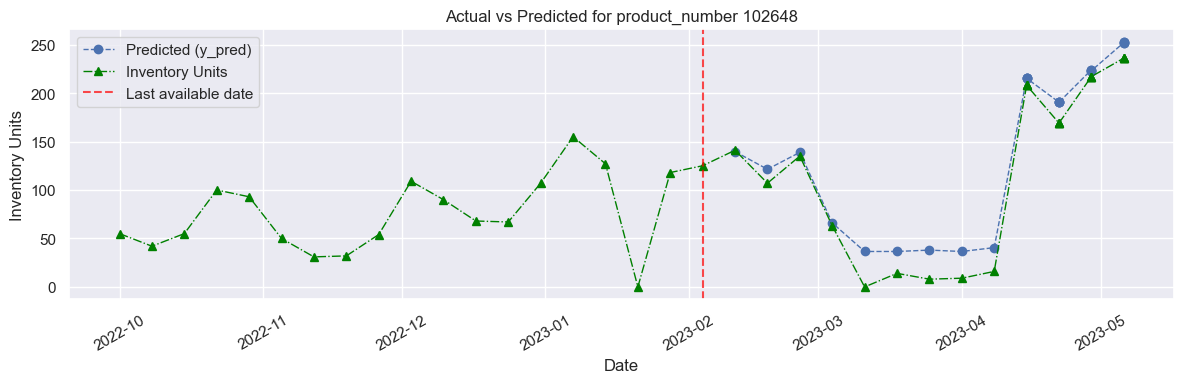

In [18]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
utils_plots.plot_real_vs_predicted(df_final.reset_index(), single_ts=102648, pred_columns=['y_pred'], col_agg='product_number', vline_dates=[date_present])